<a href="https://colab.research.google.com/github/cmunozcortes/c247-final-project/blob/main/src/C247_Final_Notebook_(SCNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODOs
Ctrl+F for most of em. At a high level:
- We need to decide whether to stick with onehot or sparse encoding for y. I'm not seeing a major performance difference.
- We need to figure out how to handle the validation dataset.
    - Unfortunately, model.fit()'s 'validation_split' arg doesn't support Dataset structures, just raw tensors (why?)
    - If we include PCA, this can get tricky as we want to train the PCA transformation ONLY on the training set
    - If we split train/val and make each their own dataset, I don't think we get k-fold cross validation
        - Do we get this with the 'validation_split' arg?

### Imports and Global Configuration

In [ ]:
import datetime

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Perform PCA
do_pca = False

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Data loading
- Converts to 32-bit floats to reduce training time
- Adjusts labels to be in the range \[0-3\]
- Generates onehot encoded copies of all values that represent a class index
    - TODO: Justification for inclusion of one hot encoding

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/c247")

# Load the data and convert from 64 to 32 bit floats
X_train_valid = np.load("data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("data/y_train_valid.npy").astype(np.float32)
person_train_valid = np.load("data/person_train_valid.npy").astype(np.float32)
X_test = np.load("data/X_test.npy").astype(np.float32)
y_test = np.load("data/y_test.npy").astype(np.float32)
person_test = np.load("data/person_test.npy").astype(np.float32)

# Print our the shapes of the data we loaded for confirmation
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

# Function to convert labels from single value class index to onehot vector
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

# Adjust the y labels to be in the range [0-3] and also generate equivalent onehot representations
y_train_valid -= 769
y_test -= 769
print('y_train_valid:', y_train_valid[:10])
print('y_test:', y_train_valid[:10])
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)
person_train_valid_1h = convert_to_one_hot(person_train_valid) # TODO remove?
person_test_1h = convert_to_one_hot(person_test) # TODO remove?
print('y_train_valid_1h:')
print(y_train_valid_1h[:4])
print('y_test_1h:')
print(y_train_valid_1h[:4])

# TODO REVIEW: Do we want to include data regarding subject classification?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid: [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]
y_test: [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]
y_train_valid_1h:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
y_test_1h:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


# Data Augmentation

Augmenting the limited training data was critical to achieve high performance on our design. Below, the loaded data is augmented in-place before being passed to any network. Many approaches were tried, and not all resulted in performance changes.

### Beneficial Augmentations
Update these fields with actual numbers when we have models included. Comment out the relevant augmentation, then rerun training and report the difference in val and/or test accuracy.
- Cropping each time-series signal to just the first 500 samples (2 seconds) of data
    - Cropping the last 500 samples seemed to net worse performance, but both are higher than the baseline 1000 samples
        - Alon, is this accuracte? Going on memory here.
    - Justification for this?
- Normalizing each time-series signal to zero mean and unit variance
    - This is not the same as 'extracting the mean image' from homeworks - every signal of every channel is modified independently.
    - This is designed so that the time domain signals have more predictable statistics.
    - Improves performance on X model by TODO percentage points.
- TODO PCA?    

### Neutral or Deterimental Augmentations
- Adding channels that were filtered to only include \mu and \beta frequencies showed no performance improvement on any model. This tripled the number of channels in each example from 22 to 66.
    - The idea was to pass the neural network better features, since the \mu and \beta frequencies are purported to be highly correlated with movement.
    - The networks we tried probably had no problem learning matched filters for these frequencies if those are beneficial filters. The first layer kernels certainly have sufficient parameters to do this in all models.
- Adding examples with varying levels of Additive White Gaussian Noise (AWGN) had no effect on performance
    - The number of examples was increase 10x (up to 21150), where every set of examples had a fixed sigma used to generate AWGN added to all channels
    - This was designed as a mitigation against overfitting, but did not seem to help with the overfitting issue.

## Data Augmentation Implementation

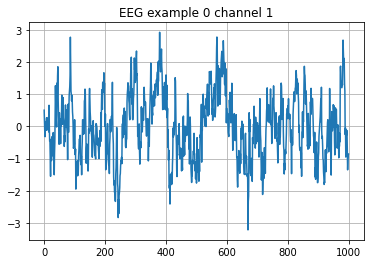

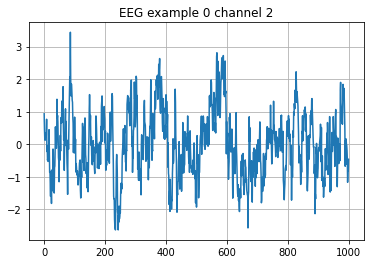

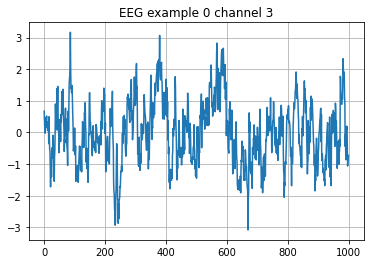

In [ ]:
# Trim all time series to the first 500 samples (2 seconds @ fs=250Hz)
#X_train_valid = X_train_valid[:,:,:500]
#X_test = X_test[:,:,:500]

# Normalize each time series signal of each channel to have zero mean and unit variance
# This is fine to do on the test set, since it is independent of example
X_train_valid -= np.expand_dims(np.mean(X_train_valid, axis=-1), -1)
X_test -= np.expand_dims(np.mean(X_test, axis=-1), -1)
X_train_valid /= np.expand_dims(np.std(X_train_valid, axis=-1), -1)
X_test /= np.expand_dims(np.std(X_test, axis=-1), -1)

# Generate some plots to visually verify
for i in range(3):
    plt.title("EEG example 0 channel %d" % (i+1))
    plt.plot(X_train_valid[0,i,:])
    plt.grid()
    plt.show()

## PCA
If we include, it's complicated enough for its own cell.

**NOTE**: If we do include this, we will need to split the test and validation sets *before* PCA. Otherwise the validation set will contribute to the choice of orthogonal basis vectors (going off of memory here.)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

if do_pca is True:
  # Split train and test data
  X_train, X_val, y_train, y_val = train_test_split(
      X_train_valid, y_train_valid_1h, test_size=0.2, random_state=0
  )

  # Independent Component Analysis
  N_train, D, T = X_train.shape
  N_val, _, _ = X_val.shape
  N_test, _, _ = X_test.shape
  n_components = 11
  transformer = PCA(n_components=n_components, random_state=0)
  transformer.fit(X_train.reshape(N_train*T, D))

  X_train_transf = transformer.transform(X_train.reshape(N_train*T, D))
  X_val_transf = transformer.transform(X_val.reshape(N_val*T, D))
  X_test_transf = transformer.transform(X_test.reshape(N_test*T, D))

  X_train_transf = X_train_transf.reshape(N_train, n_components, T)
  X_val_transf = X_val_transf.reshape(N_val, n_components, T)
  X_test_transf = X_test_transf.reshape(N_test, n_components, T)

  print(X_train_transf.shape)
  print(X_val_transf.shape)
  print(X_test_transf.shape)

# Conversion to TensorFlow Data Structures

TODO: We should make train, val, and test datasets. The val_split arg for model.fit() only works on tensors. We should be smart about this with PCA to avoid data leakage. The below is not used for now.

In [ ]:
# Create train+val and test datasets for normal and onehot representations
train_val_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid, y_train_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle our train+val set
train_val_dataset = train_val_dataset.shuffle(100).batch(64)
test_dataset = test_dataset.batch(64)

# Print key metrics on the dataset
print(train_val_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(None, 22, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 22, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


# Models

In [ ]:
class ExpandLayer(layers.Layer):

    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super(ExpandLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        ax = self.axis
        input_shape = list(input_shape)
        if ax < 0:
            ax = len(input_shape) + ax
        input_shape.insert(ax+1, 1)
        return tuple(input_shape)

    def call(self, inputs, **kwargs):
        return tf.expand_dims(inputs, axis=self.axis)

    def get_config(self):
        return dict(axis=self.axis)

In [ ]:
def SCNN(inputshape, outputshape, params=None):

    params = dict() if params is None else params

    temp_layers = int(params.get('temp_layers', 4))
    steps = int(params.get('steps', 2))
    temporal = int(params.get('temporal', 24))
    temp_pool = int(params.get('temp_pool', 20))
    lunits = [int(x) for x in params.get('lunits', [200, 40])]
    activation = params.get('activation', keras.activations.selu)
    reg = float(params.get('regularization', 0.01))
    do = min(1., max(0., float(params.get('dropout', 0.55))))

    convs = [inputshape[-1] // steps for _ in range(1, steps)]
    convs += [inputshape[-1] - sum(convs) + len(convs)]

    ins = keras.layers.Input(inputshape)

    #conv = ExpandLayer()(ins)
    conv = keras.layers.Reshape((inputshape[0], inputshape[1], 1))(ins)

    for i, c in enumerate(convs):
        conv = keras.layers.Conv2D(
            lunits[0] // len(convs), (1, c),
            activation=activation,
            use_bias=False, 
            name='spatial_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg),
            data_format='channels_last')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.SpatialDropout2D(do/2)(conv)

    for i in range(temp_layers):
        conv = keras.layers.Conv2D(
            lunits[1], (temporal, 1),
            activation=activation,
            use_bias=False, name='temporal_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg),
            data_format='channels_last')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.AveragePooling2D((temp_pool, 1))(conv)
    conv = keras.layers.SpatialDropout2D(do/2)(conv)

    outs = keras.layers.Flatten()(conv)

    for units in lunits[2:]:
        outs = keras.layers.Dense(
            units, activation=activation,
            kernel_regularizer=keras.layers.regularizers.l2(reg))(outs)
        outs = keras.layers.BatchNormalization()(outs)
        outs = keras.layers.Dropout(do)(outs)
    outs = keras.layers.Dense(
        outputshape, activation='softmax', name='OUT',
        kernel_regularizer=tf.keras.regularizers.l2(reg))(outs)

    return keras.models.Model(ins, outs)

In [ ]:
# Reshape data for SCNN model
#N_train, D, T = X_train_valid.shape

#X_train_valid = X_train_valid.reshape((N_train, T, D))
#X_test = X_test.reshape((X_test.shape[0], T, D))

#X_train_valid.shape[1:]
X_train_valid = X_train_valid.transpose((0,2,1))
model = SCNN(inputshape=X_train_valid.shape[1:], outputshape=4)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
spatial_conv_0 (Conv2D)      (None, 1000, 12, 100)     1100      
_________________________________________________________________
spatial_conv_1 (Conv2D)      (None, 1000, 1, 100)      120000    
_________________________________________________________________
batch_normalization_5 (Batch (None, 1000, 1, 100)      400       
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 1000, 1, 100)      0         
_________________________________________________________________
temporal_conv_0 (Conv2D)     (None, 977, 1, 40)        9600

In [ ]:
# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]

loss_hist = model.fit(
    X_train_valid, y_train_valid_1h,
    validation_split=0.2,
    batch_size=60,
    epochs=100,
    verbose=2,
    callbacks=callbacks,
)

# Evaluate model on test dataset
print('\nTest accuracy')
print(model.evaluate(X_test.transpose((0,2,1)), y_test_1h))

Epoch 1/100
29/29 - 2s - loss: 4.4260 - categorical_accuracy: 0.2742 - val_loss: 4.3521 - val_categorical_accuracy: 0.3215

Epoch 00001: val_categorical_accuracy improved from -inf to 0.32151, saving model to best_model.h5
Epoch 2/100
29/29 - 1s - loss: 3.9130 - categorical_accuracy: 0.3895 - val_loss: 3.8277 - val_categorical_accuracy: 0.3522

Epoch 00002: val_categorical_accuracy improved from 0.32151 to 0.35225, saving model to best_model.h5
Epoch 3/100
29/29 - 1s - loss: 3.5476 - categorical_accuracy: 0.4728 - val_loss: 3.5158 - val_categorical_accuracy: 0.4019

Epoch 00003: val_categorical_accuracy improved from 0.35225 to 0.40189, saving model to best_model.h5
Epoch 4/100
29/29 - 1s - loss: 3.2571 - categorical_accuracy: 0.5420 - val_loss: 3.3073 - val_categorical_accuracy: 0.4704

Epoch 00004: val_categorical_accuracy improved from 0.40189 to 0.47045, saving model to best_model.h5
Epoch 5/100
29/29 - 1s - loss: 3.0049 - categorical_accuracy: 0.5833 - val_loss: 3.1335 - val_categ